## Superstore Profit-loss prediction 

Part 2: Prediction of profit-loss values instead of classifying the records as profitable and non-profitable records

**Importing Required Modules and tools**

In [71]:
#Data Pre-processing
import numpy as np
import pandas as pd
from imblearn.combine import SMOTETomek

#Data Visualization 
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

#Machine Learning 
from sklearn.preprocessing import RobustScaler,StandardScaler,LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split,StratifiedKFold,GridSearchCV,RandomizedSearchCV,KFold
from sklearn.linear_model import LinearRegression,Lasso,Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor,VotingRegressor
from sklearn.metrics import mean_absolute_error,mean_squared_error, median_absolute_error
from sklearn.feature_selection import SelectKBest,f_regression

import pickle

**Loading Data**

In [72]:
data = pd.read_csv("SampleSuperStore.csv")
data.head(4)

,Ship Mode,Segment,Country,City,State,Postal Code,Region,Category,Sub-Category,Sales,Quantity,Discount,Profit
0,Second Class,Consumer,United States,Henderson,Kentucky,42420,South,Furniture,Bookcases,261.9600,2,0.00,41.9136
1,Second Class,Consumer,United States,Henderson,Kentucky,42420,South,Furniture,Chairs,731.9400,3,0.00,219.5820
2,Second Class,Corporate,United States,Los Angeles,California,90036,West,Office Supplies,Labels,14.6200,2,0.00,6.8714
3,Standard Class,Consumer,United States,Fort Lauderdale,Florida,33311,South,Furniture,Tables,957.5775,5,0.45,-383.0310


In [73]:
data.describe()

,Postal Code,Sales,Quantity,Discount,Profit
count,9994.000000,9994.000000,9994.000000,9994.000000,9994.000000
mean,55190.379428,229.857901,3.789574,0.156203,28.656599
std,32063.693350,623.245124,2.225110,0.206452,234.260115
min,1040.000000,0.444000,1.000000,0.000000,-6599.978000
25%,23223.000000,17.280000,2.000000,0.000000,1.728750
50%,56430.500000,54.490000,3.000000,0.200000,8.666500
75%,90008.000000,209.940000,5.000000,0.200000,29.364000
max,99301.000000,22638.480000,14.000000,0.800000,8399.976000


**Data Pre-processsing**

- Removing redundant columns

In [74]:
data.iloc[:,2].value_counts()

United States    9994
Name: Country, dtype: int64

Entire country columns consists of same values : "United States", thus we will drop the Country column since it will not contribute much in EDA

In [75]:
data.drop(columns={"Country"},inplace=True)

In [76]:
data.columns

Index(['Ship Mode', 'Segment', 'City', 'State', 'Postal Code', 'Region',
       'Category', 'Sub-Category', 'Sales', 'Quantity', 'Discount', 'Profit'],
      dtype='object')

- Adding temporary columns for future use

In [77]:
data["Status"]=np.where(data["Profit"]>0,"Profit",np.where(data["Profit"]<0,"Loss","B/E"))
data.head(3)

,Ship Mode,Segment,City,State,Postal Code,Region,Category,Sub-Category,Sales,Quantity,Discount,Profit,Status
0,Second Class,Consumer,Henderson,Kentucky,42420,South,Furniture,Bookcases,261.96,2,0.0,41.9136,Profit
1,Second Class,Consumer,Henderson,Kentucky,42420,South,Furniture,Chairs,731.94,3,0.0,219.5820,Profit
2,Second Class,Corporate,Los Angeles,California,90036,West,Office Supplies,Labels,14.62,2,0.0,6.8714,Profit


<u>Data Transformation</u>

- Scaling continious data

In [78]:
print(data.select_dtypes(include=["float64","int64"]).drop(columns={"Postal Code","Profit"}).columns)

Index(['Sales', 'Quantity', 'Discount'], dtype='object')


Since Profit column consists of target values, not going to scale it.

Scaling the data by setting pipline for consisting of robust scaler and standard scaler

In [79]:
pipeline = Pipeline([
    ("robust_scaler",RobustScaler()),
    ("std_scaler",StandardScaler())
])

In [80]:
to_be_processed = data.select_dtypes(include=["float64","int64"]).drop(columns={"Postal Code","Profit"})
to_be_processed.columns

Index(['Sales', 'Quantity', 'Discount'], dtype='object')

In [81]:
for col in to_be_processed.columns:
    data[col] = pipeline.fit_transform(np.array(data[col]).reshape(-1,1))
    pickle.dump(pipeline,open(f"{col}pipeline.pkl","wb"))

In [82]:
data.head(3)

,Ship Mode,Segment,City,State,Postal Code,Region,Category,Sub-Category,Sales,Quantity,Discount,Profit,Status
0,Second Class,Consumer,Henderson,Kentucky,42420,South,Furniture,Bookcases,0.051511,-0.804303,-0.756643,41.9136,Profit
1,Second Class,Consumer,Henderson,Kentucky,42420,South,Furniture,Chairs,0.805634,-0.354865,-0.756643,219.5820,Profit
2,Second Class,Corporate,Los Angeles,California,90036,West,Office Supplies,Labels,-0.345368,-0.804303,-0.756643,6.8714,Profit


- Encoding categorical data to numeric data

In [83]:
le = LabelEncoder()
for col in data.select_dtypes(include="object").drop(columns={"Status"}).columns:
    data[col] = le.fit_transform(data[col])
    pickle.dump(le,open(f"{col}encoder.pkl","wb"))
data.head(3)

,Ship Mode,Segment,City,State,Postal Code,Region,Category,Sub-Category,Sales,Quantity,Discount,Profit,Status
0,2,0,194,15,42420,2,0,4,0.051511,-0.804303,-0.756643,41.9136,Profit
1,2,0,194,15,42420,2,0,5,0.805634,-0.354865,-0.756643,219.5820,Profit
2,2,1,266,3,90036,3,1,10,-0.345368,-0.804303,-0.756643,6.8714,Profit


- Temporary Features and Labels

In [14]:
Xt = data.drop(columns={"Status"})
yt = data["Status"]

Xt.shape,yt.shape

((9994, 12), (9994,))

<u>Data Balancing</u>

In [15]:
smt = SMOTETomek(random_state=10)
smt

SMOTETomek(random_state=10)

In [16]:
X_res,y_res = smt.fit_resample(Xt,yt)

In [17]:
X_res.shape,y_res.shape

((24100, 12), (24100,))

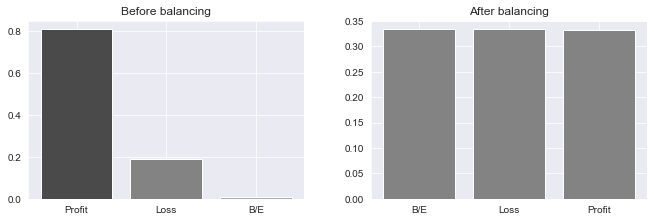

In [18]:
sns.set_style("darkgrid")
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.bar(yt.value_counts(normalize=True).index,
        yt.value_counts(normalize=True).values,
       color=["#4A4A4A","#838383","#ADACAC"])
plt.title("Before balancing")

plt.subplot(1,2,2)
plt.bar(y_res.value_counts(normalize=True).index,
        y_res.value_counts(normalize=True).values,
       color=["#838383","#838383","#838383"])
plt.title("After balancing")

plt.tight_layout(pad=4)
plt.show()

<u>Features and labels</u>

In [19]:
#Features
X = X_res.drop(columns={"Profit"})

#labels
y = X_res["Profit"]

X.shape,y.shape

((24100, 11), (24100,))

<u>Splitting Data</u>
- Splitting the data into training data and testing data

In [20]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,shuffle=True,random_state=10)

<u> Model Selection </u>
- Selecting regression model 

*Linear Regression ,Lasso Regression ,Ridge Regression model*

- Linear Regression model

In [21]:
linearR_model = LinearRegression()
linearR_model.fit(X_train,y_train)

LinearRegression()

In [22]:
y_pred = linearR_model.predict(X_test)
mean_absolute_error(y_test, y_pred)

58.567654546235815

- Lasso Regression model

In [23]:
x = Lasso()
lasso_param_grid = {"alpha":[1,2,3,4]}
gs = GridSearchCV(x,param_grid=lasso_param_grid,cv=5)
gs.fit(X_train,y_train)
gs.best_params_

{'alpha': 1}

In [24]:
lassoR_model = gs.best_estimator_

In [25]:
y_pred = lassoR_model.predict(X_test)
mean_absolute_error(y_test, y_pred)

57.66390646761623

- Ridge Regression model

In [26]:
x = Ridge()
lasso_param_grid = {"alpha":range(6)}
gs = GridSearchCV(x,param_grid=lasso_param_grid,cv=5)
gs.fit(X_train,y_train)
gs.best_params_

{'alpha': 5}

In [27]:
ridgeR_model = gs.best_estimator_

In [28]:
y_pred = ridgeR_model.predict(X_test)

In [29]:
 mean_absolute_error(y_test, y_pred)

58.55864245734407

*KNN model*

In [30]:
x = KNeighborsRegressor()
knn_param_grid={"n_neighbors":range(2,8),
              "metric":["manhattan","euclidean","minkowski","cosine"]}
gs = GridSearchCV(x,param_grid=knn_param_grid,cv=5)
gs.fit(X_train,y_train)
gs.best_params_

{'metric': 'cosine', 'n_neighbors': 2}

In [31]:
knn_model = gs.best_estimator_

In [32]:
y_pred = knn_model.predict(X_test)

In [33]:
 mean_absolute_error(y_test, y_pred)

34.431722519427055

*SVM model*

In [34]:
# x = SVR()
# svr_param_grid = {"C":range(1,20,3),
#                  "kernel":["rbf","linear","poly","sigmoid"]}
# gs = GridSearchCV(x,param_grid=svr_param_grid,cv=5)
# gs.fit(X_train,y_train)
# gs.best_params_

In [35]:
# svm_model = gs.best_estimator_

Reason : SVR Taking too much time

*Random Forest Model*

In [36]:
x = RandomForestRegressor()
rfr_param_grid = {"n_estimators":np.arange(10,100,10),
                  "max_depth":[None,3,5,10],
                  "min_samples_split":np.arange(2,20,2),
                  "min_samples_leaf":np.arange(1,20,2),
                  "max_features":range(2,10,2),
                  "max_samples":[10000]}
rs = RandomizedSearchCV(x,param_distributions=rfr_param_grid,n_iter=15,cv=5)
rs.fit(X_train,y_train)
rs.best_params_

{'n_estimators': 10,
 'min_samples_split': 4,
 'min_samples_leaf': 1,
 'max_samples': 10000,
 'max_features': 4,
 'max_depth': None}

In [37]:
rfr_model = rs.best_estimator_

In [38]:
y_pred = rfr_model.predict(X_test)

In [39]:
 mean_absolute_error(y_test, y_pred)

20.862397645473308

*Gradient Boosting Model*

In [40]:
x = GradientBoostingRegressor()
gbr_param_grid = {"n_estimators":np.arange(10,100,10),
                  "learning_rate":[0.1,0.05,0.02],
                  "min_samples_leaf":np.arange(1,20,2),
                  "max_depth":[1,2,3,None],
                  "max_features":range(2,10,2)}
rs = RandomizedSearchCV(x,param_distributions=gbr_param_grid,n_iter=15,cv=5)
rs.fit(X_train,y_train)
rs.best_params_

{'n_estimators': 90,
 'min_samples_leaf': 19,
 'max_features': 6,
 'max_depth': None,
 'learning_rate': 0.1}

In [41]:
gbr_model = rs.best_estimator_

In [42]:
y_pred = gbr_model.predict(X_test)

In [43]:
 mean_absolute_error(y_test, y_pred)

15.628098815043424

*Voting Regressor*

Voting Classifier is a machine learning model that trains on an ensemble of numerous models and predicts an output (class) based on their highest probability of chosen class as the output.

In [44]:
estimator = []
classifiers,models = ["Linear_R","Lasso_R","Ridge_R","KNN","RF","GB"],\
[linearR_model,lassoR_model,ridgeR_model,knn_model,rfr_model,gbr_model] 
for i,j in zip(classifiers,models):
    estimator.append((i,j))
estimator

[('Linear_R', LinearRegression()),
 ('Lasso_R', Lasso(alpha=1)),
 ('Ridge_R', Ridge(alpha=5)),
 ('KNN', KNeighborsRegressor(metric='cosine', n_neighbors=2)),
 ('RF',
  RandomForestRegressor(max_features=4, max_samples=10000, min_samples_split=4,
                        n_estimators=10)),
 ('GB',
  GradientBoostingRegressor(max_depth=None, max_features=6, min_samples_leaf=19,
                            n_estimators=90))]

In [45]:
model = VotingRegressor(estimators=estimator)
model.fit(X_train,y_train)

VotingRegressor(estimators=[('Linear_R', LinearRegression()),
                            ('Lasso_R', Lasso(alpha=1)),
                            ('Ridge_R', Ridge(alpha=5)),
                            ('KNN',
                             KNeighborsRegressor(metric='cosine',
                                                 n_neighbors=2)),
                            ('RF',
                             RandomForestRegressor(max_features=4,
                                                   max_samples=10000,
                                                   min_samples_split=4,
                                                   n_estimators=10)),
                            ('GB',
                             GradientBoostingRegressor(max_depth=None,
                                                       max_features=6,
                                                       min_samples_leaf=19,
                                                       n_estimators=90))])

In [46]:
y_pred = model.predict(X_test)

In [47]:
 mean_absolute_error(y_test, y_pred)

36.98213041659113

<u> Model Validation </u>

- Applying Stratified KFold

In [48]:
kfold = KFold(n_splits=15,shuffle=True,random_state=11)
errors = []
for train_index,test_index in kfold.split(X,y):
    X_train,X_test = X.iloc[train_index,:],X.iloc[test_index,:]
    y_train,y_test = y.iloc[train_index],y.iloc[test_index]
    gbr_model.fit(X_train,y_train)
    pred_values = gbr_model.predict(X_test)
    errors.append(mean_absolute_error(y_test,pred_values))
print("Model Error : ",np.array(errors).mean())

Model Error :  14.009766427001578


In [49]:
pd.DataFrame({"Split number":range(1,16),"Error":errors})

,Split number,Error
0,1,17.397596
1,2,14.276215
2,3,11.457554
3,4,15.875514
4,5,11.516658
5,6,13.835162
6,7,17.497901
7,8,14.031166
8,9,14.403209
9,10,11.105263


<u>Feature selection</u>
- Checking model score before and after selecting 4 to 11 best features
- Best parameters for max features for random forest classifier and gradient boost classifier are 2, 4 respectively
- Thus we can not select features less than 4

In [50]:
test_errors,train_errors = [],[]
for i in range(8,len(X.columns)+1):
    X_new = SelectKBest(f_regression, k=i).fit_transform(X, y)
    X_train,X_test,y_train,y_test = train_test_split(X_new,y,test_size=0.3,shuffle=True,random_state=10)
    m1 = gbr_model.fit(X_train,y_train)
    train_pred = gbr_model.predict(X_train)
    test_pred = gbr_model.predict(X_test)
    train_errors.append(mean_absolute_error(y_train,train_pred))
    test_errors.append(mean_absolute_error(y_test,test_pred))

In [51]:
feature_selection = pd.DataFrame({
    "Total Features":range(8,len(X.columns)+1),
    "Train Errors":train_errors,
    "Test Errors":test_errors,
    "Feature Selection":["Yes"]*4
})
feature_selection.loc[(feature_selection["Total Features"]==11),"Feature Selection"]="No"
feature_selection.nsmallest(11,columns=["Train Errors","Test Errors"])

,Total Features,Train Errors,Test Errors,Feature Selection
3,11,7.020971,15.693676,No
2,10,7.615703,15.670875,Yes
1,9,8.039652,16.179504,Yes
0,8,8.473966,16.606209,Yes


<u>Final Model</u>

- Gradient Boosting Regressor is the best model as it gives minimum error and no need for feature selection as all the features provide with the best performance

In [52]:
final_model = gbr_model
final_model

GradientBoostingRegressor(max_depth=None, max_features=6, min_samples_leaf=19,
                          n_estimators=90)

<u>Pickling model and other objects</u>

In [53]:
pickle.dump(final_model,open("final_model.pkl","wb"))